# Competition 1, Sem 1, Yandex SHAD, Fall 2021

**Предскажите победу Radiant в игре Dota 2 по первым минутам матча**

## Данные

Для каждого матча вам предоставлена различная информация за первые 10 минут игры.

__train.csv__

Данный файл содержит информацию о том выиграла ли команда radiant в матче с идентификатором mid.

Каждая строчка файла содержит следующие колонки:

* mid — идентификатор матча
* radiant_won — факт того, что в игре победила команда radiant

__test.csv__

В данном файле содержатся идентификаторы игр для которых нужно сделать предсказание о победе команды radiant.

Каждая строчка файла содержит следующие колонки:

* mid — идентификатор матча

__gold.csv__

Данный файл содержит снимки данных игры, содержащих количество золота для каждого игрока.

Каждая строчка файла содержит следующие колонки:

* mid — идентификатор матча
* times — время в секундах когда был сделан снимок
* player_0, player_1, player_2, player_3, player_4 — количество золота для игроков команды radiant
* player_5, player_6, player_7, player_8, player_9 — количество золота для игроков команды dire

__lh.csv__

Данный файл содержит снимки данных, содержащих количество убитых нейтральных монстров (крипов) для каждого игрока.

Каждая строчка файла содержит следующие колонки:

* mid — идентификатор матча
* times — время в секундах когда был сделан снимок
* player_0, player_1, player_2, player_3, player_4 — количество убитых монстров для игроков команды radiant
* player_5, player_6, player_7, player_8, player_9 — количество убитых монстров для игроков команды dire

__xp.csv__

Данный файл содержит снимки данных, содержащих количество заработанного опыта для каждого игрока.

Каждая строчка файла содержит следующие колонки:

* mid — идентификатор матча
* times — время в секундах когда был сделан снимок
* player_0, player_1, player_2, player_3, player_4 — количество заработанного опыта для игроков команды radiant
* player_5, player_6, player_7, player_8, player_9 — количество заработанного опыта для игроков команды dire

__items.csv__

Разреженная матрица содержащая информацию о предметах, которые успели купить игроки за первые 10 минут игры.

Каждая строчка файла содержит следующие колонки:

* mid — идентификатор матча
* player — идентификатор игрока, с 0 по 4 игроки команды radiant, с 5 по 9 игроки команды dire
* item_0, ... , item_120 — количество купленных предметов

__heroes.csv__

Данный файл содержит информацию о типах героев, которые были выбраны игроки в каждом матче.

Каждая строчка файла содержит следующие колонки:

* mid — идентификатор матча
* player_0, player_1, player_2, player_3, player_4 — типы героев, выбранных игроками команды radiant
* player_5, player_6, player_7, player_8, player_9 — типы героев, выбранных игроками команды dire

__events.csv__

Данный файл содержит информацию о событиях, которые произошли в каждом матче.

Каждая строчка файла содержит следующие колонки:

* mid — идентификатор матча
* event_type — тип события
    * 0 — Командой был забран Aegis
    * 1 — Командой был украден Aegis
    * 2 — Командой были разрушены бараки соперника
    * 3 — Командой был сделано первое убийство героя соперника
    * 4 — Командой был убит Roshan.
    * 5 — Командой была разрушена своя башня
    * 6 — Командой была разрушена башня соперника
* from_team — название команды, которое инициировало событие
* time — время в секундах от старта игры когда событие произошло

## Таргет

В качестве метрики качества используется __ROC AUC__

Отправлять необходимо файл с двумя колонками:

* mid — идентификатор матча в тестовой выборке
* radiant_won — предсказанная __вероятность__ того, что команда Radiant является победителем в игре

## Imports

In [99]:
import pandas as pd
import numpy as np
from tqdm import tqdm 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import warnings
warnings.filterwarnings('ignore')

## EDA & Feature Generation

In [2]:
fldr = 'competition-1-sem-1-yandex-shad-fall-2021'
data = [
    'train.csv', 'test.csv',
    'gold.csv', 'lh.csv', 'xp.csv', 'items.csv', 'heroes.csv', 'events.csv'
    'deny.csv', 'kills.csv'
]

In [3]:
train = pd.read_csv(f'{fldr}/train.csv')
test = pd.read_csv(f'{fldr}/test.csv')
gold = pd.read_csv(f'{fldr}/gold.csv')
lasthit = pd.read_csv(f'{fldr}/lh.csv')
xp = pd.read_csv(f'{fldr}/xp.csv')
items = pd.read_csv(f'{fldr}/items.csv')
heroes = pd.read_csv(f'{fldr}/heroes.csv')
events = pd.read_csv(f'{fldr}/events.csv')
deny = pd.read_csv(f'{fldr}/deny.csv')
kills = pd.read_csv(f'{fldr}/kills.csv')

### train

In [4]:
train.head(2)

,mid,radiant_won
0,0,1
1,1,0


In [5]:
train['radiant_won'].value_counts()

1    12974
0    12000
Name: radiant_won, dtype: int64

### test

In [6]:
test.head(2)

,mid
0,3
1,7


In [7]:
test.shape

(24974, 1)

### gold

* player_0, player_1, player_2, player_3, player_4 — количество золота для игроков команды radiant
* player_5, player_6, player_7, player_8, player_9 — количество золота для игроков команды dire

In [8]:
gold.head(2)

,mid,times,player_0,player_1,player_2,player_3,player_4,player_5,player_6,player_7,player_8,player_9
0,0,60,750,350,389,437,428,398,344,654,287,1056
1,0,120,957,1071,633,655,1080,669,1147,1164,438,1360


In [9]:
def add_agg_features_per_team(df_, suffix):
    df = df_.copy(deep=True)
    radiant = pd.Series(zip(df['player_0'], df['player_1'], df['player_2'], df['player_3'], df['player_4']))
    dire = pd.Series(zip(df['player_5'], df['player_6'], df['player_7'], df['player_8'], df['player_9']))

    df[f'radiant_{suffix}_min'] = radiant.apply(np.min)
    df[f'radiant_{suffix}_mean'] = radiant.apply(np.mean)
    df[f'radiant_{suffix}_max'] = radiant.apply(np.max)
    df[f'radiant_{suffix}_std'] = radiant.apply(np.std)

    df[f'dire_{suffix}_min'] = dire.apply(np.min)
    df[f'dire_{suffix}_mean'] = dire.apply(np.mean)
    df[f'dire_{suffix}_max'] = dire.apply(np.max)
    df[f'dire_{suffix}_std'] = dire.apply(np.std)
    
    return df

In [10]:
%%time
gold_600_only = gold.loc[gold['times'] == 600].reset_index(drop=True)
gold_new = add_agg_features_per_team(gold_600_only, 'gold')

CPU times: user 4.49 s, sys: 38.7 ms, total: 4.53 s
Wall time: 4.5 s


In [11]:
gold_new

,mid,times,player_0,player_1,player_2,player_3,player_4,player_5,player_6,player_7,player_8,player_9,radiant_gold_min,radiant_gold_mean,radiant_gold_max,radiant_gold_std,dire_gold_min,dire_gold_mean,dire_gold_max,dire_gold_std
0,0,600,3454,5206,2613,4426,5755,4072,3997,5917,1725,6384,2613,4290.8,5755,1141.490149,1725,4419.0,6384,1652.958439
1,1,600,2477,5760,3816,4353,5759,7659,5066,2748,4440,4623,2477,4433.0,5760,1243.561820,2748,4907.2,7659,1584.853987
2,2,600,3604,1948,8581,4390,2869,3096,2301,5130,2530,2491,1948,4278.4,8581,2297.686193,2301,3109.6,5130,1044.474720
3,3,600,3457,5464,4432,2961,4314,3345,4791,1906,5328,2247,2961,4125.6,5464,863.019026,1906,3523.4,5328,1352.064880
4,4,600,3675,4103,5154,3030,2076,3920,3494,3392,4458,2220,2076,3607.6,5154,1031.575223,2220,3496.8,4458,740.839092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49943,49943,600,3754,3556,5388,3391,5634,2853,4447,3636,8245,5598,3391,4344.6,5634,962.422693,2853,4955.8,8245,1879.030324
49944,49944,600,4895,2580,4109,5610,2732,3564,5763,5538,4005,3027,2580,3985.2,5610,1185.591397,3027,4379.4,5763,1085.425373
49945,49945,600,2325,1813,2530,4807,5542,2242,2359,5997,5523,2044,1813,3403.4,5542,1483.162108,2044,3633.0,5997,1746.051202
49946,49946,600,4134,3141,4086,4405,3517,2887,7450,3634,5431,5451,3141,3856.6,4405,459.941127,2887,4970.6,7450,1594.870854


In [12]:
drop_cols = ['times', 
             'player_0', 'player_1', 'player_2', 'player_3', 'player_4',
             'player_5', 'player_6', 'player_7', 'player_8', 'player_9']
gold_features = gold_new.drop(drop_cols, axis=1).reset_index(drop=True)

In [13]:
gold_features.head(2)

,mid,radiant_gold_min,radiant_gold_mean,radiant_gold_max,radiant_gold_std,dire_gold_min,dire_gold_mean,dire_gold_max,dire_gold_std
0,0,2613,4290.8,5755,1141.490149,1725,4419.0,6384,1652.958439
1,1,2477,4433.0,5760,1243.561820,2748,4907.2,7659,1584.853987


### lasthit

In [14]:
lasthit.head(2)

,mid,times,player_0,player_1,player_2,player_3,player_4,player_5,player_6,player_7,player_8,player_9
0,0,60,1,2,1,1,2,3,2,7,1,2
1,0,120,1,5,1,2,6,5,6,14,1,6


In [15]:
%%time
lasthit_600_only = lasthit.loc[lasthit['times'] == 600].reset_index(drop=True)
lasthit_new = add_agg_features_per_team(lasthit_600_only, 'lh')

CPU times: user 4.44 s, sys: 80.5 ms, total: 4.52 s
Wall time: 4.46 s


In [16]:
lasthit_features = lasthit_new.drop(drop_cols, axis=1).reset_index(drop=True)

In [17]:
lasthit_features.head(2)

,mid,radiant_lh_min,radiant_lh_mean,radiant_lh_max,radiant_lh_std,dire_lh_min,dire_lh_mean,dire_lh_max,dire_lh_std
0,0,3,29.6,57,22.014541,2,38.4,75,23.465720
1,1,5,31.4,63,21.228283,3,28.8,49,15.574338


### xp

In [18]:
xp.head(2)

,mid,times,player_0,player_1,player_2,player_3,player_4,player_5,player_6,player_7,player_8,player_9
0,0,60,79,214,147,222,147,94,78,396,94,147
1,0,120,321,719,423,777,421,490,607,895,241,365


In [19]:
%%time
xp_600_only = xp.loc[xp['times'] == 600].reset_index(drop=True)
xp_new = add_agg_features_per_team(xp_600_only, 'xp')

CPU times: user 4.36 s, sys: 52.6 ms, total: 4.41 s
Wall time: 4.37 s


In [20]:
xp_features = xp_new.drop(drop_cols, axis=1).reset_index(drop=True)

In [21]:
xp_features.head(2)

,mid,radiant_xp_min,radiant_xp_mean,radiant_xp_max,radiant_xp_std,dire_xp_min,dire_xp_mean,dire_xp_max,dire_xp_std
0,0,1606,3171.2,4429,1258.062224,357,2986.0,4846,1534.721082
1,1,1542,3046.2,4810,1340.227055,2248,3467.4,4514,724.726045


### items

* player — идентификатор игрока, с 0 по 4 игроки команды radiant, с 5 по 9 игроки команды dire
* item_0, ... , item_120 — количество купленных предметов

In [22]:
items.head(11)

,mid,player,item_0,item_1,item_2,item_3,item_4,item_5,item_6,item_7,...,item_111,item_112,item_113,item_114,item_115,item_116,item_117,item_118,item_119,item_120
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,3,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
5,0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
6,0,6,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
7,0,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
items['team'] = items['player'].apply(lambda x: 'radiant' if x < 5 else 'dire')
items_per_team = items.drop('player', axis=1).groupby(['mid', 'team']).sum().reset_index()

In [24]:
items_pivoted = items_per_team.pivot(index='mid', columns='team', values=[f'item_{x}' for x in range(121)])
items_pivoted.columns = [f'{x[1]}_{x[0]}' for x in items_pivoted.columns]
items_features = items_pivoted.reset_index()

In [25]:
items_features.head(2)

,mid,dire_item_0,radiant_item_0,dire_item_1,radiant_item_1,dire_item_2,radiant_item_2,dire_item_3,radiant_item_3,dire_item_4,...,dire_item_116,radiant_item_116,dire_item_117,radiant_item_117,dire_item_118,radiant_item_118,dire_item_119,radiant_item_119,dire_item_120,radiant_item_120
0,0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### heroes

In [26]:
heroes.head(2)

,mid,player_0,player_1,player_2,player_3,player_4,player_5,player_6,player_7,player_8,player_9
0,0,91,42,87,15,65,11,6,34,69,74
1,1,69,85,71,24,64,74,68,39,65,11


In [27]:
heroes.nunique()

mid         49948
player_0      111
player_1      111
player_2      111
player_3      111
player_4      111
player_5      111
player_6      111
player_7      111
player_8      111
player_9      111
dtype: int64

In [28]:
heroes_radiant = pd.Series(zip(heroes['player_0'], heroes['player_1'], heroes['player_2'], 
                               heroes['player_3'], heroes['player_4']))
heroes_dire = pd.Series(zip(heroes['player_5'], heroes['player_6'], heroes['player_7'], 
                            heroes['player_8'], heroes['player_9']))
heroes['radiant'] = heroes_radiant
heroes['dire'] = heroes_dire

In [29]:
heroes.head(3)

,mid,player_0,player_1,player_2,player_3,player_4,player_5,player_6,player_7,player_8,player_9,radiant,dire
0,0,91,42,87,15,65,11,6,34,69,74,"(91, 42, 87, 15, 65)","(11, 6, 34, 69, 74)"
1,1,69,85,71,24,64,74,68,39,65,11,"(69, 85, 71, 24, 64)","(74, 68, 39, 65, 11)"
2,2,17,40,31,67,99,32,7,72,48,104,"(17, 40, 31, 67, 99)","(32, 7, 72, 48, 104)"


In [30]:
heroes_new = heroes.copy(deep=True)

for i in tqdm(range(111)):
    heroes_new[f'radiant_hero_{i}'] = heroes['radiant'].apply(lambda x: int(i in x))
    heroes_new[f'dire_hero_{i}'] = heroes['dire'].apply(lambda x: int(i in x))

100%|██████████| 111/111 [00:03<00:00, 28.99it/s]


In [31]:
drop_cols = ['player_0', 'player_1', 'player_2', 'player_3', 'player_4',
             'player_5', 'player_6', 'player_7', 'player_8', 'player_9', 
             'radiant', 'dire']
heroes_features = heroes_new.drop(drop_cols, axis=1).reset_index(drop=True)

In [32]:
heroes_features.head(2)

,mid,radiant_hero_0,dire_hero_0,radiant_hero_1,dire_hero_1,radiant_hero_2,dire_hero_2,radiant_hero_3,dire_hero_3,radiant_hero_4,...,radiant_hero_106,dire_hero_106,radiant_hero_107,dire_hero_107,radiant_hero_108,dire_hero_108,radiant_hero_109,dire_hero_109,radiant_hero_110,dire_hero_110
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### events

* event_type — тип события
    * 0 — Командой был забран Aegis
    * 1 — Командой был украден Aegis
    * 2 — Командой были разрушены бараки соперника
    * 3 — Командой был сделано первое убийство героя соперника
    * 4 — Командой был убит Roshan.
    * 5 — Командой была разрушена своя башня
    * 6 — Командой была разрушена башня соперника

In [33]:
events.head(3)

,mid,event_type,from_team,time
0,0,3,radiant,1
1,1,3,radiant,222
2,2,3,dire,143


In [34]:
events_new = heroes_features[['mid']]
events_radiant = events.loc[events['from_team'] == 'radiant'].groupby('mid')['event_type'].apply(list).reset_index()\
                    .rename(index=str, columns={'event_type': 'radiant_events'})
events_dire = events.loc[events['from_team'] == 'dire'].groupby('mid')['event_type'].apply(list).reset_index()\
                    .rename(index=str, columns={'event_type': 'dire_events'})

In [35]:
events_new_types = pd.merge(events_new, events_radiant, on='mid', how='left')
events_new_types = pd.merge(events_new_types, events_dire, on='mid', how='left')

In [36]:
events_new_types_feats = events_new_types.copy(deep=True)

for i in tqdm(range(7)):
    events_new_types_feats[f'radiant_event_{i}'] = events_new_types['radiant_events']\
        .apply(lambda x: sum([1 for event in x if event == i]) if isinstance(x, list) else 0)
    events_new_types_feats[f'dire_event_{i}'] = events_new_types['dire_events']\
        .apply(lambda x: sum([1 for event in x if event == i]) if isinstance(x, list) else 0)

100%|██████████| 7/7 [00:00<00:00, 25.17it/s]


In [37]:
drop_cols = ['radiant_events', 'dire_events']
events_features = events_new_types_feats.drop(drop_cols, axis=1).reset_index(drop=True)

In [38]:
events_features.head(2)

,mid,radiant_event_0,dire_event_0,radiant_event_1,dire_event_1,radiant_event_2,dire_event_2,radiant_event_3,dire_event_3,radiant_event_4,dire_event_4,radiant_event_5,dire_event_5,radiant_event_6,dire_event_6
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0


### deny

In [39]:
deny.head(2)

,mid,time,player_0,player_1,player_2,player_3,player_4,player_5,player_6,player_7,player_8,player_9
0,0,60,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,0,120,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [40]:
%%time
deny_600_only = deny.loc[deny['time'] == 600].reset_index(drop=True)
deny_new = add_agg_features_per_team(deny_600_only, 'deny')

CPU times: user 7.38 s, sys: 111 ms, total: 7.49 s
Wall time: 7.41 s


In [41]:
drop_cols = ['time', 
             'player_0', 'player_1', 'player_2', 'player_3', 'player_4',
             'player_5', 'player_6', 'player_7', 'player_8', 'player_9']
deny_features = deny_new.drop(drop_cols, axis=1).reset_index(drop=True)

In [42]:
deny_features.head(2)

,mid,radiant_deny_min,radiant_deny_mean,radiant_deny_max,radiant_deny_std,dire_deny_min,dire_deny_mean,dire_deny_max,dire_deny_std
0,0,-1,-1.0,-1,0.0,-1,-1.0,-1,0.0
1,1,-1,-1.0,-1,0.0,-1,-1.0,-1,0.0


### kills

In [43]:
kills.head(2)

,mid,time,killer,victim_id
0,8004,116,player_1,103
1,8004,122,player_4,100


In [44]:
kills['team'] = 'dire'
kills.loc[kills['killer'].isin(['player_0', 'player_1', 'player_2', 'player_3', 'player_4']), 'team'] = 'radiant'
kills_agg = kills.groupby(['mid', 'team'])['victim_id'].count().reset_index()

In [45]:
kills_features = kills_agg.pivot(index='mid', columns='team', values='victim_id').reset_index()\
                            .rename(index=str, columns={'dire': 'dire_kills', 'radiant': 'radiant_kills'})

In [46]:
kills_features.head()

team,mid,dire_kills,radiant_kills
0,8004,1.0,7.0
1,12048,5.0,3.0
2,12920,1.0,5.0
3,15026,11.0,2.0
4,16204,10.0,6.0


## Dataset creation & Preproccessing

### Train

In [47]:
y = train['radiant_won']
X = pd.merge(train[['mid']], gold_features, on='mid', how='left')
X = pd.merge(X, lasthit_features, on='mid', how='left')
X = pd.merge(X, xp_features, on='mid', how='left')
X = pd.merge(X, items_features, on='mid', how='left')
X = pd.merge(X, heroes_features, on='mid', how='left')
X = pd.merge(X, events_features, on='mid', how='left')
X = pd.merge(X, deny_features, on='mid', how='left')
X = pd.merge(X, kills_features, on='mid', how='left').fillna(0)
X = X.drop('mid', axis=1)

In [48]:
X.isna().sum().max()

0

### Test

In [49]:
X_test = pd.merge(test, gold_features, on='mid', how='left')
X_test = pd.merge(X_test, lasthit_features, on='mid', how='left')
X_test = pd.merge(X_test, xp_features, on='mid', how='left')
X_test = pd.merge(X_test, items_features, on='mid', how='left')
X_test = pd.merge(X_test, heroes_features, on='mid', how='left')
X_test = pd.merge(X_test, events_features, on='mid', how='left')
X_test = pd.merge(X_test, deny_features, on='mid', how='left')
X_test = pd.merge(X_test, kills_features, on='mid', how='left').fillna(0)
X_test = X_test.drop('mid', axis=1)

In [50]:
X_test.isna().sum().max()

0

## Save dataset

In [54]:
X_ = X.copy(deep=True)
X_['radiant_won'] = y

X_.to_csv(f'{fldr}/dataset_train.csv', index=False)
X_test.to_csv(f'{fldr}/dataset_test.csv', index=False)

## Load dataset

In [121]:
X_ = pd.read_csv(f'{fldr}/dataset_train.csv')
X = X_.drop('radiant_won', axis=1)
y = X_['radiant_won']
X_test = pd.read_csv(f'{fldr}/dataset_test.csv')

#### Remove deny/kills features

In [127]:
new_cols = [x for x in X.columns if ('kills' in x) or ('deny' in x)]
X = X.drop(new_cols, axis=1)
X_test = X_test.drop(new_cols, axis=1)

### Fit scaler on union of train/test

In [141]:
%%time
all_data = np.vstack([X, X_test])

scaler = MinMaxScaler()
# scaler = StandardScaler()
scaler = scaler.fit(all_data)

CPU times: user 204 ms, sys: 36.7 ms, total: 241 ms
Wall time: 239 ms


### Apply scaler on train and test

In [142]:
X_scaled = scaler.transform(X)
X_test_scaled = scaler.transform(X_test)

In [143]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

## Modeling & Evaluation

In [111]:
%%time
grid = {
        "penalty": ['l1', 'l2', 'elasticnet'],
        "C": np.logspace(0.01, 2, 5), 
        "solver": ['liblinear', 'saga'],
        "class_weight": ['balanced', None],
        "l1_ratio": [0.3, 0.7]
}

clf = LogisticRegression(max_iter=300,
                         random_state=42)
clf_cv = GridSearchCV(clf, grid, cv=5, scoring='roc_auc', verbose=True)
clf_cv.fit(X_train, y_train)

print("Best parameters:", clf_cv.best_params_)
print("ROC AUC:", clf_cv.best_score_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed: 99.5min finished


Best parameters: {'C': 1.023292992280754, 'class_weight': 'balanced', 'l1_ratio': 0.3, 'penalty': 'l1', 'solver': 'liblinear'}
ROC AUC: 0.7587094674359551
CPU times: user 1h 50min 36s, sys: 13.7 s, total: 1h 50min 50s
Wall time: 1h 39min 32s


In [144]:
clf_best = LogisticRegression(max_iter=1000, 
                              random_state=42,
                              **clf_cv.best_params_
                             )
clf_best.fit(X_train, y_train)

y_val_pred = clf_best.predict(X_val)
y_val_pred_proba = clf_best.predict_proba(X_val)[:,1]

print("ROC AUC:", roc_auc_score(y_val, y_val_pred_proba)) 

ROC AUC: 0.7673001398521563


### Feature importance

In [146]:
features_weights = pd.DataFrame(zip(X.columns, clf_best.coef_[0]), columns=['feature', 'weight'])\
                    .sort_values(by='weight', ascending=False).reset_index(drop=True)
features_weights_best = pd.concat([features_weights.head(20), features_weights.tail(20)]) 

Text(0.5, 1.0, 'Features Weights (Top-10 per high/low)')

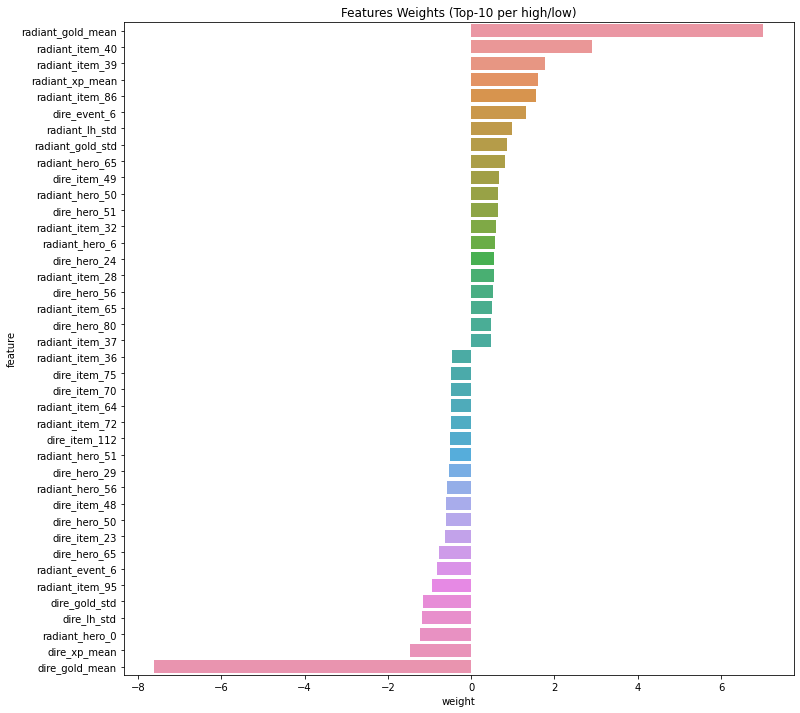

In [147]:
plt.figure(figsize=(12,12))
sns.barplot(x="weight", y="feature", data=features_weights_best)
plt.title('Features Weights (Top-10 per high/low)')

## Saving prediction

In [148]:
%%time
test_preds = test.copy(deep=True)
clf_best.fit(X_scaled, y)
test_preds['radiant_win'] = clf_best.predict_proba(X_test_scaled)[:,1]

CPU times: user 5.73 s, sys: 16.2 ms, total: 5.74 s
Wall time: 5.72 s


In [149]:
test_preds

,mid,radiant_win
0,3,0.679590
1,7,0.527534
2,9,0.163711
3,10,0.315722
4,12,0.525787
...,...,...
24969,49936,0.639541
24970,49942,0.418771
24971,49943,0.400701
24972,49944,0.416866


In [136]:
# test_preds.to_csv('predictions_Erin_v3.csv', sep=',', index=False)